In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import numpy as np
import re
import os
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn import preprocessing
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from numpy import array
from numpy import hstack
from statsmodels.graphics.gofplots import qqplot
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense,Bidirectional,Dropout
from tensorflow.keras import regularizers
import keras
import matplotlib
%matplotlib inline

- Why is the regression model over-estimating in some provinces and not in the others?
- Why is the regression model performing well on some health regions and not the well for the others, even in the same province?
    - Ans: Since there are provinces with really high cumulative death counts like Montreal hubs around 3400 and Toronto hub around 1100, the model is able to capture the general trend of a period with a short gap between the prediction and actual value. Like the middle death counts of Peel, Ottawa, and York hubs, the prediction is oscillating, but the gap range is around 20 to 40. For the low death counts like Sun County, Kelsey Trail, and Far north hubs in SK, the cumulative death counts are below 5, the prediction overall has a higher rate than the actual value since most pandemic hubs have higher death count rate than these provinces.

- More research on regression model

## Parameter label: cumulative death 
df_merge_model = label('cumulative_deaths')

In [4]:
## Run
## change label: df_merge_model = label('cumulative_cases')
## process data
conn = sqlite3.connect('../data/hubs.db')
df_mob = pd.read_sql_query("SELECT * from Mobility_HR_V", conn)
df_mob_sort = df_mob.sort_values(by=['HR_UID','DATE'])
df_health = pd.read_sql_query("SELECT * from Health_Indicators_ODHF", conn)
df_health1 = df_health[['HR_UID','Population_density', 'ambulatory','hospitals','nursing_residential', 'Perceived_health_good', 'Perceived_health_poor']]
mob_health = pd.merge(df_mob, df_health1, how='left', on=['HR_UID'])
df_COVID = pd.read_sql_query("SELECT * from Covid19", conn)
# total cols of 2 dataframe merged
new = df_COVID['HR_UID'].str.split(".", n = 1, expand = True) 
df_COVID['HR_UID']= new[0]
pd_merge = pd.merge(mob_health, df_COVID, how='right', left_on=['DATE', 'HR_UID'], right_on=['report_date', 'HR_UID'])
# mob_health date '2020-07-05'
max_date = mob_health['DATE'].max()
max_date1 = df_COVID['report_date'].max()
if max_date<max_date1:
    max_dt = max_date
else:
    max_dt= max_date1
pd_merge_new = pd_merge.loc[(pd_merge['DATE']>='2020-01-25') & (pd_merge['DATE']<=max_dt)]
# dropping duplicte values on same HR_UID and Date
pd_merge_new.drop_duplicates(subset =["HR_UID", "DATE"], inplace = True) 
# minmax scaler
scaler = MinMaxScaler()
# minmax scaler
scaler1 = MinMaxScaler()
# add and remove cumulative_deaths, cumulative_cases
def label(label):
    lst = ['Md_PD', 'Mrr_PD',
        'Mgp_PD', 'Mp_PD', 'Mt_PD', 'Mw_PD', 'Mr_PD', 'M_PD', 'Md_MD',
        'Mrr_MD', 'Mgp_MD', 'Mp_MD', 'Mt_MD', 'Mw_MD', 'Mr_MD', 'M_MD','Md_RP', 'Mrr_RP',
       'Mgp_RP', 'Mp_RP', 'Mt_RP', 'Mw_RP', 'Mr_RP', 'M_RP', 'Md_MP', 'Mrr_MP',
       'Mgp_MP', 'Mp_MP', 'Mt_MP', 'Mw_MP', 'Mr_MP', 'M_MP','cases', 'cumulative_cases', 'deaths',
       'cumulative_deaths', 'Population_density','ambulatory','hospitals','nursing_residential']
    lst.remove(label)
    data = pd_merge_new[lst]

    data1 = pd_merge_new[[label]]
    data_scale = scaler.fit_transform(data)
    data_scale1 = scaler1.fit_transform(data1)
    df_data_scale = pd.DataFrame(data=data_scale,columns=lst)
    df_data_scale1 = pd.DataFrame(data=data_scale1,columns=[label])
    col_lst = list(set(pd_merge_new.columns.tolist()) - set(df_data_scale.columns.tolist())- set(df_data_scale1.columns.tolist()))
    col_lst.append('PRUID_x')
    pd_feature = pd_merge_new[col_lst]
    pd_feature.reset_index(inplace=True)
    df_merge_model = pd.concat([pd_feature, df_data_scale, df_data_scale1], axis=1)
    return df_merge_model

df_merge_model = label('cumulative_deaths')
df_merge_model.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


index PRUID_x                    HR_NAME report_date HR_UID        DATE  \
0      0      35  Peel Regional Health Unit  2020-01-25   3553  2020-01-25   
1      1      35  Peel Regional Health Unit  2020-01-26   3553  2020-01-26   
2      2      35  Peel Regional Health Unit  2020-01-27   3553  2020-01-27   
3      3      35  Peel Regional Health Unit  2020-01-28   3553  2020-01-28   
4      4      35  Peel Regional Health Unit  2020-01-29   3553  2020-01-29   

      PROV PRUID_y health_region  Perceived_health_poor  ...     Mr_MP  \
0  Ontario      35          peel                  0.106  ...  0.192156   
1  Ontario      35          peel                  0.106  ...  0.193353   
2  Ontario      35          peel                  0.106  ...  0.194550   
3  Ontario      35          peel                  0.106  ...  0.195747   
4  Ontario      35          peel                  0.106  ...  0.196944   

       M_MP  cases  cumulative_cases  deaths  Population_density  ambulatory  \
0  0.621375    0.0               0.0     0.0            0.255652         1.0   
1  0.433864    0.0               0.0     0.0            0.255652         1.0   
2  0.511814    0.0               0.0     0.0            0.255652         1.0   
3  0.550314    0.0               0.0     0.0            0.255652         1.0   
4  0.568802    0.0               0.0     0.0            0.255652         1.0   

   hospitals  nursing_residential  cumulative_deaths  
0   0.714286                  1.0                0.0  
1   0.714286                  1.0                0.0  
2   0.714286                  1.0                0.0  
3   0.714286                  1.0                0.0  
4   0.714286                  1.0                0.0  

[5 rows x 52 columns]

In [1]:
df_merge_model['report_date'].max()

NameError: name 'df_merge_model' is not defined

## Parameter label: time lag
df_new1 = shift_df(['HR_UID','cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP'],5)
## Parameter prediction period: '1daypred' or '5daypred'
df_hr_dum = pred_preiod('1daypred')

In [238]:
## Run
## change the label df_label = df_hr[['cumulative_cases_x']]
## change time_lag features
# # shift the value upward
df_merge_model['report_date'] = pd.to_datetime(df_merge_model['report_date'])
# df1 = df.set_index('DATE')
df_new = df_merge_model[['HR_UID', 'report_date','cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP', 'report_date']]

def shift_df(lst, lag_date):
    for date in range(0, lag_date):
        lag_date_run = date+1
        for a in lst:
            col_name = a + str('_-'+str(lag_date_run))
            val = -lag_date_run
            df_new[col_name] = df_new.groupby(['HR_UID'])[a].shift(val)
    return df_new


def shift_label(label, ahead_date):
    col_name = str('la-'+label)
    df_new2[col_name] = df_new2.groupby(['HR_UID'])[label].shift(ahead_date)
    return df_new2

df_new1 = shift_df(['HR_UID','cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP'],5)
# remove null row
df_new1.dropna(inplace=True)
# drop duplicated columns
df_new2 = df_new1.loc[:,~df_new1.columns.duplicated()]

def pred_preiod(predtime):
    if predtime=='5daypred':
        df_new3 = shift_label('cumulative_deaths',5)
        # remove null row
        df_new3.dropna(inplace=True)
        # drop duplicated columns
        df_new4 = df_new3.loc[:,~df_new3.columns.duplicated()]

        ## Merge df back with health indicator
        df_new5 = pd.merge(df_merge_model, df_new4, how='left', on=['HR_UID','report_date'])
        # remove null row
        df_new5.dropna(inplace=True)
        # drop duplicated columns
        df_new6 = df_new5.loc[:,~df_new5.columns.duplicated()]
        # df_on = df_new4.loc[df_new4['PRUID_x']==str(35)]
        df_dum_HR = pd.get_dummies(df_new6.HR_UID, prefix='HR_UID')
        df_hr_dum = pd.concat([df_new6, df_dum_HR], axis=1)
    elif predtime=='1daypred':
        ## Merge df back with health indicator
        df_new3 = pd.merge(df_merge_model, df_new2, how='left', on=['HR_UID','report_date'])
        # remove null row
        df_new3.dropna(inplace=True)
        # drop duplicated columns
        df_new4 = df_new3.loc[:,~df_new3.columns.duplicated()]
        # df_on = df_new4.loc[df_new4['PRUID_x']==str(35)]
        df_dum_HR = pd.get_dummies(df_new4.HR_UID, prefix='HR_UID')
        df_hr_dum = pd.concat([df_new4, df_dum_HR], axis=1)

    return df_hr_dum

df_hr_dum = pred_preiod('5daypred')
# select one hr
def df_filter(hr, case, lag_date, predtime):
    df_hr = df_hr_dum.loc[df_hr_dum['HR_UID']==str(hr)]
    df_train = df_hr.loc[(df_hr['report_date'] >= df_hr['report_date'].min()) & (df_hr['report_date'] < '2020-07-01')]
    df_eval = df_hr.loc[(df_hr['report_date'] >= '2020-07-01') & (df_hr['report_date'] <= df_hr['report_date'].max())]
    # list for input lagged features
    lst = ['cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP']
    col_lst = []
    for date in range(0, lag_date):
        lag_date_run = date+1
        for a in lst:
            col_name = a + str('_-'+str(lag_date_run))
            col_lst.append(col_name)
            
    lst1 = ['Mt_RP_x', 'Mt_MP_x', 'Mw_MD_x', 'Mgp_RP_x', 'Population_density','ambulatory',
               'hospitals','nursing_residential', 'Perceived_health_good', 'Perceived_health_poor']
    col_lst+=lst1
    col_lst+=df_dum_HR.columns.tolist()
    
    if case:
        col_lst.append('cases_x')
    if predtime=='5daypred':
        label = 'la-cumulative_deaths'
    elif predtime=='1daypred':
        label = 'cumulative_deaths_x'
    # train set
    df_feature_train = df_train[col_lst]
    df_label_train = df_train[[label]]
    # eval set
    df_feature_val = df_eval[col_lst]
    df_label_val = df_eval[[label]]
    # drop duplicated columns
    df_hr1 = df_hr.loc[:,~df_hr.columns.duplicated()]
   
    return df_feature_train, df_label_train, df_feature_val, df_label_val, df_hr1



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


## Input Data
- 2D time steps data

## Parameter prediction period: '1daypred' or '5daypred'
feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5,'1daypred')


In [239]:
## Run
# split_sequences to change the dimensions of input
X_train_lst = []
X_test_lst = []
y_train_lst = []
y_test_lst = []
X_val_lst = []
y_val_lst = []

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps, label_seq):
    label_seq = label_seq.reshape(label_seq.shape[0], -1)
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], label_seq[end_ix-1, :]
#         seq_x = sequences[i:end_ix, :]
        X.append(seq_x)
        y.append(seq_y)

    return array(X), array(y).reshape(-1)

for hr in df_hr_dum['HR_UID'].unique().tolist():
    
    feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5,'5daypred')
    
    X_train = feature_train
    X_test = feature_val
    y_train = label_train
    y_test = label_val
  
    # train data
    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    X_train_lst.append(X_train_3d)
    X_test_lst.append(X_test_3d)
    y_train_lst.append(y_train)
    y_test_lst.append(y_test)

    
X_train = np.concatenate(X_train_lst, axis=0)
# X_train.shape (4182, 2, 101)
X_test = np.concatenate(X_test_lst, axis=0)
y_train = np.concatenate(y_train_lst, axis=0)
# Y_train.shape (4182,)
y_test = np.concatenate(y_test_lst, axis=0)

Y_train = y_train.reshape(-1,)
Y_test = y_test.reshape(-1,)
# Y_val = y_val.reshape(-1,)
Y_train.shape

(16371,)

In [240]:
## Run
n_sample = 1
n_step = X_train.shape[0]
n_features = X_train.shape[-1]
x_train = X_train.reshape(n_step, -1,n_features)
x_test = X_test.reshape(X_test.shape[0], -1,X_test.shape[-1])

x_train.shape
# (108, 1,  11)

(16371, 1, 158)

In [95]:
def lstm(x_train, Y_train, X_test, y_test, n_step, n_features, input_LSTM):
    model = Sequential()
    model.add(LSTM(input_LSTM, activation='relu', input_shape=(n_step, n_features)))
    model.add(Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=opt, metrics=['mse','mae'])
    # fit model
    history =model.fit(x_train, Y_train, epochs=50, verbose=2, validation_data=(X_test, y_test))
    return history, model

In [96]:
def lstm_2layer(x_train, Y_train, X_test, y_test, n_step, n_features, input_LSTM):
    model = Sequential()
    model.add(LSTM(input_LSTM, activation='relu', input_shape=(n_step, n_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(30, activation='relu'))
    model.add(Dense(1, kernel_regularizer=regularizers.l2(0.01)))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mse', optimizer=opt, metrics=['mse','mae'])
    # fit model
    history =model.fit(x_train, Y_train, epochs=50, verbose=2, validation_data=(X_test, y_test))
    return history, model

In [ ]:
history_90, model_90 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80, model_80 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60, model_60 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)
history_50, model_50 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 50)
history_90_2, model_90_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80_2, model_80_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60_2, model_60_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)

Train on 16371 samples, validate on 5028 samples
Epoch 1/50
 - 12s - loss: 0.0063 - mse: 5.3069e-04 - mae: 0.0069 - val_loss: 5.5657e-04 - val_mse: 9.0427e-05 - val_mae: 0.0054
Epoch 2/50
 - 9s - loss: 2.6353e-04 - mse: 1.1122e-04 - mae: 0.0037 - val_loss: 1.4899e-04 - val_mse: 8.4882e-05 - val_mae: 0.0043
Epoch 3/50
 - 10s - loss: 1.3698e-04 - mse: 8.7905e-05 - mae: 0.0035 - val_loss: 1.8803e-04 - val_mse: 1.5177e-04 - val_mae: 0.0053
Epoch 4/50
 - 9s - loss: 1.6396e-04 - mse: 1.2724e-04 - mae: 0.0040 - val_loss: 2.2100e-04 - val_mse: 1.8000e-04 - val_mae: 0.0067
Epoch 5/50
 - 9s - loss: 1.0756e-04 - mse: 7.3871e-05 - mae: 0.0031 - val_loss: 1.0714e-04 - val_mse: 7.7298e-05 - val_mae: 0.0043
Epoch 6/50
 - 10s - loss: 1.3598e-04 - mse: 1.0473e-04 - mae: 0.0036 - val_loss: 2.3035e-04 - val_mse: 2.0467e-04 - val_mae: 0.0041
Epoch 7/50
 - 10s - loss: 1.0900e-04 - mse: 8.1132e-05 - mae: 0.0030 - val_loss: 5.7213e-05 - val_mse: 2.9651e-05 - val_mae: 0.0027
Epoch 8/50
 - 10s - loss: 1.1763e-

In [20]:
import keras
model_90.save("Classify_update/reg_model/mdel90_1d_reg_5le3")
model_80.save("Classify_update/reg_model/mdel80_1d_reg_5le3")
model_60.save("Classify_update/reg_model/mdel60_1d_reg_5le3")
model_90_2.save("Classify_update/reg_model/mdel902_1d_reg_5le3")
model_80_2.save("Classify_update/reg_model/mdel802_1d_reg_5le3")
model_60_2.save("Classify_update/reg_model/mdel602_1d_reg_5le3")

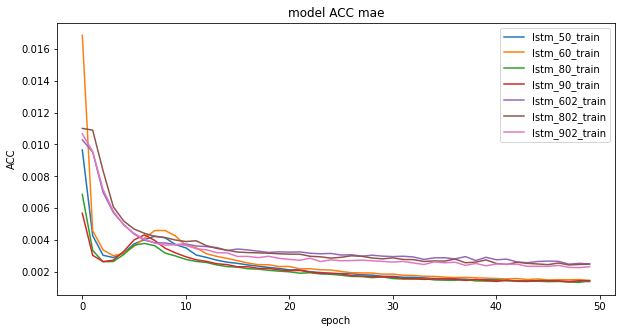

In [9]:
# with lagged 7 features
# summarize hissavetory for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(history_50.history['mae'])
plt.plot(history_60.history['mae'])
plt.plot(history_80.history['mae'])
plt.plot(history_90.history['mae'])
plt.plot(history_60_2.history['mae'])
plt.plot(history_80_2.history['mae'])
plt.plot(history_90_2.history['mae'])


# plt.plot(history_80.history['mae'])
# plt.plot(history.history['val_mae'])
plt.title('model ACC mae')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_50_train', 'lstm_60_train', 'lstm_80_train', 'lstm_90_train', 'lstm_602_train',
           'lstm_802_train', 'lstm_902_train'], loc='upper right')
# plt.savefig('photo/Multivariate/mae_train_lag.png')
plt.show()

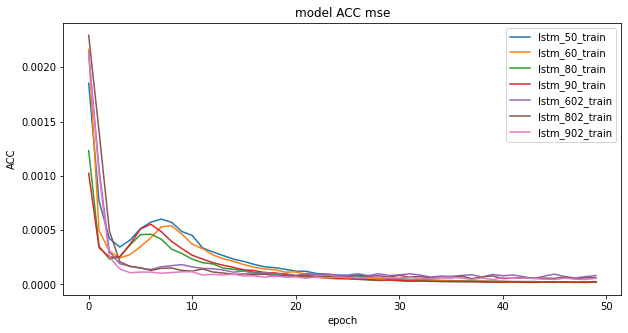

In [10]:
# with lagged 7 features
# summarize hissavetory for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(history_50.history['mse'])
plt.plot(history_60.history['mse'])
plt.plot(history_80.history['mse'])
plt.plot(history_90.history['mse'])
plt.plot(history_60_2.history['mse'])
plt.plot(history_80_2.history['mse'])
plt.plot(history_90_2.history['mse'])

plt.title('model ACC mse')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_50_train', 'lstm_60_train', 'lstm_80_train', 'lstm_90_train',
           'lstm_602_train',
           'lstm_802_train', 'lstm_902_train'], loc='upper right')
# plt.savefig('photo/Multivariate/mse_train_lag.png')
plt.show()

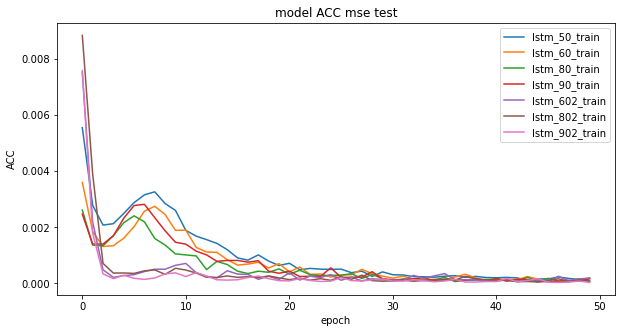

In [11]:
# with lagged 7 features
# summarize hissavetory for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))

plt.plot(history_50.history['val_mse'])
plt.plot(history_60.history['val_mse'])
plt.plot(history_80.history['val_mse'])
plt.plot(history_90.history['val_mse'])
plt.plot(history_60_2.history['val_mse'])
plt.plot(history_80_2.history['val_mse'])
plt.plot(history_90_2.history['val_mse'])


plt.title('model ACC mse test')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_50_train', 'lstm_60_train', 'lstm_80_train', 'lstm_90_train','lstm_602_train',
           'lstm_802_train', 'lstm_902_train'], loc='upper right')
# plt.savefig('photo/Multivariate/mse_test_lag.png')
plt.show()

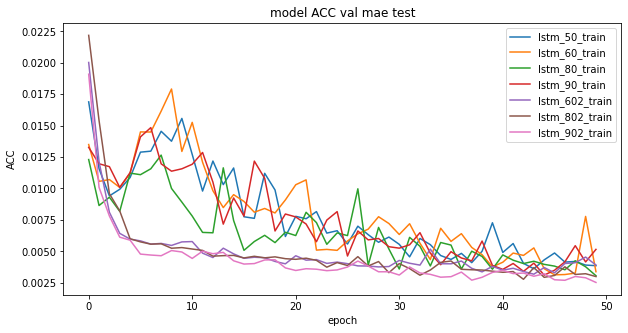

In [12]:
plt.figure(figsize=(10, 5))

plt.plot(history_50.history['val_mae'])
plt.plot(history_60.history['val_mae'])
plt.plot(history_80.history['val_mae'])
plt.plot(history_90.history['val_mae'])
plt.plot(history_60_2.history['val_mae'])
plt.plot(history_80_2.history['val_mae'])
plt.plot(history_90_2.history['val_mae'])


plt.title('model ACC val mae test')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_50_train', 'lstm_60_train', 'lstm_80_train', 'lstm_90_train','lstm_602_train',
           'lstm_802_train', 'lstm_902_train'], loc='upper right')
# plt.savefig('photo/Multivariate/mse_test_lag.png')
plt.show()

In [34]:
import keras
model_90.save("Classify_update/reg_model/mdel90_1d_reg_5le")
model_80.save("Classify_update/reg_model/mdel80_1d_reg_5le")
model_60.save("Classify_update/reg_model/mdel60_1d_reg_5le")
model_90_2.save("Classify_update/reg_model/mdel902_1d_reg_5le")
model_80_2.save("Classify_update/reg_model/mdel802_1d_reg_5le")
model_60_2.save("Classify_update/reg_model/mdel602_1d_reg_5le")

In [135]:
model_80_2 = keras.models.load_model("Classify_update/reg_model/mdel802_1d_reg_5le2")
model_90_2 = keras.models.load_model("Classify_update/reg_model/mdel902_1d_reg_5le2")
model_60_2 = keras.models.load_model("Classify_update/reg_model/mdel602_1d_reg_5le2")
model_90 = keras.models.load_model("Classify_update/reg_model/mdel90_1d_reg_5le2")
model_80 = keras.models.load_model("Classify_update/reg_model/mdel80_1d_reg_5le2")
model_60 = keras.models.load_model("Classify_update/reg_model/mdel60_1d_reg_5le2")


In [261]:
model_60_2 = keras.models.load_model("Classify_update/reg_model/mdel602_1d_reg_5le3")

In [33]:
## Run
min_rmse_lst = []

for hr in df_hr_dum['HR_UID'].unique().tolist():
    
    feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5)
    X_train = feature_train
    X_test = feature_val
    y_train = label_train
    y_test = label_val
    
    # train data
    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    n_sample = 1
    n_step = X_train_3d.shape[0]
    n_features = X_train_3d.shape[-1]
    
    prediction_90 = model_90.predict(X_test_3d).flatten()
    prediction_80 = model_80.predict(X_test_3d).flatten()
    prediction_60 = model_60.predict(X_test_3d).flatten()
    prediction_90_2 = model_90_2.predict(X_test_3d).flatten()
    prediction_80_2 = model_80_2.predict(X_test_3d).flatten()
    prediction_60_2 = model_60_2.predict(X_test_3d).flatten()
    
    prediction_90 = prediction_90.reshape(-1, 1)
    prediction_80 = prediction_80.reshape(-1, 1)
    prediction_60 = prediction_60.reshape(-1, 1)
    prediction_90_2 = prediction_90_2.reshape(-1, 1)
    prediction_80_2 = prediction_80_2.reshape(-1, 1)
    prediction_60_2 = prediction_60_2.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    test_inv = scaler1.inverse_transform(y_test)
    inv_90 = scaler1.inverse_transform(prediction_90)
    inv_80 = scaler1.inverse_transform(prediction_80)
    inv_60 = scaler1.inverse_transform(prediction_60)
    inv_90_2 = scaler1.inverse_transform(prediction_90_2)
    inv_80_2 = scaler1.inverse_transform(prediction_80_2)
    inv_60_2 = scaler1.inverse_transform(prediction_60_2)
    
    rmse_90 = mean_squared_error(test_inv, inv_90, squared=False)
    rmse_80 = mean_squared_error(test_inv, inv_80, squared=False)
    rmse_60 = mean_squared_error(test_inv, inv_60, squared=False)
    rmse_90_2 = mean_squared_error(test_inv, inv_90_2, squared=False)
    rmse_80_2 = mean_squared_error(test_inv, inv_80_2, squared=False)
    rmse_60_2 = mean_squared_error(test_inv, inv_60_2, squared=False)

    result_dict = {}
    result_dict['rmse 90'] = rmse_90
    result_dict['rmse 80'] = rmse_80
    result_dict['rmse 60'] = rmse_60
    result_dict['rmse 90_2'] = rmse_90_2
    result_dict['rmse 80_2'] = rmse_80_2
    result_dict['rmse 60_2'] = rmse_60_2
    
    min_rmse = min(result_dict, key=result_dict.get)
    
    min_rmse_lst.append(min_rmse)
    
def most_frequent(List): 
    counter = 0
    num = List[0] 
      
    for i in List: 
        curr_frequency = List.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 
  
    return num 
  
    
print('The lease rmse from lstm model:',most_frequent(min_rmse_lst))
  

The lease rmse from lstm model: rmse 90


In [55]:
import keras
model_90 = keras.models.load_model("Classify_update/reg_model/mdel90_1d_l2_reg")

In [10]:
import keras
model_90.save("Classify_update/reg_model/mdel90_1d_reg")
model_80.save("Classify_update/reg_model/mdel80_1d_reg")
model_60.save("Classify_update/reg_model/mdel60_1d_reg")
model_90_2.save("Classify_update/reg_model/mdel902_1d_reg")
model_80_2.save("Classify_update/reg_model/mdel802_1d_reg")
model_60_2.save("Classify_update/reg_model/mdel602_1d_reg")


In [264]:

def hr_plot(hr):    
    feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5,'5daypred')
    X_train = feature_train
    X_test = feature_val
    y_train = label_train
    y_test = label_val

    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    
    n_sample = 1
    n_step = X_test_3d.shape[0]
    n_features = X_test_3d.shape[-1]
    
    then = df_hr1['report_date'].max()

    end_date = datetime.strftime(then + timedelta(1), '%Y-%m-%d')
    date_end_date = datetime.strptime(end_date, '%Y-%m-%d')

    fst_date = datetime.strftime(then - timedelta(len(X_test_3d)-1), '%Y-%m-%d')
    date_fst_date = datetime.strptime(fst_date, '%Y-%m-%d')


    days = mdates.drange(date_fst_date,date_end_date,dt.timedelta(days=1))


    prediction_90_2 = model_60_2.predict(X_test_3d).flatten()
    
    y_test = y_test.reshape(-1, 1)
    prediction_90_2 = prediction_90_2.reshape(-1, 1)
    
    test_inv = scaler1.inverse_transform(y_test)
    inv_90_2 = scaler1.inverse_transform(prediction_90_2)
    
    return days, test_inv, inv_90_2
    
plt.gcf().set_size_inches(25, 12)  

days, test_inv, inv_90_2 = hr_plot('2406')

plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('montréal pandemic hub')
plt.legend(['prediction_80_2', 'actual'])
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('2416')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('montérégie pandemic hub')
plt.legend(['prediction_80_2', 'actual'])
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('2413')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('laval pandemic hub')
plt.legend(['prediction_80_2', 'actual'])
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('2414')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('lanaudière pandemic hub')
plt.legend(['prediction_80_2', 'actual'])
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('2415')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('laurentides pandemic hub')
plt.legend(['prediction_80_2', 'actual'])
plt.savefig('Classify_update/Reg_0.05_LR_0.0001/QC_5day_L20.05_LR_0.0001.png')
    
    

In [265]:

def hr_plot(hr):    
    feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5,'5daypred')
    X_train = feature_train
    X_test = feature_val
    y_train = label_train
    y_test = label_val

    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    
    n_sample = 1
    n_step = X_test_3d.shape[0]
    n_features = X_test_3d.shape[-1]
    
    then = df_hr1['report_date'].max()

    end_date = datetime.strftime(then + timedelta(1), '%Y-%m-%d')
    date_end_date = datetime.strptime(end_date, '%Y-%m-%d')

    fst_date = datetime.strftime(then - timedelta(len(X_test_3d)-1), '%Y-%m-%d')
    date_fst_date = datetime.strptime(fst_date, '%Y-%m-%d')


    days = mdates.drange(date_fst_date,date_end_date,dt.timedelta(days=1))


    prediction_90_2 = model_60_2.predict(X_test_3d).flatten()
    
    y_test = y_test.reshape(-1, 1)
    prediction_90_2 = prediction_90_2.reshape(-1, 1)
    
    test_inv = scaler1.inverse_transform(y_test)
    inv_90_2 = scaler1.inverse_transform(prediction_90_2)
    
    return days, test_inv, inv_90_2
    
plt.gcf().set_size_inches(25, 12)  

days, test_inv, inv_90_2 = hr_plot('3595')

plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('Toronto pandemic hub')
plt.legend(['prediction', 'actual'])
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('3553')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('Peel pandemic hub')
plt.legend(['prediction', 'actual'])
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('3551')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('Ottawa pandemic hub')
plt.legend(['prediction', 'actual'])
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('3570')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('york pandemic hub')
plt.legend(['prediction', 'actual'])
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('3530')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('durham pandemic hub')
plt.legend(['prediction', 'actual'])
plt.savefig('Classify_update/Reg_0.05_LR_0.0001/ON_5day_L20.05_LR_0.0001.png')
# plt.savefig('photo/Reg_plot/mdl90_reg_l2_ON.png')
    
    

In [266]:

def hr_plot(hr):    
    feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5,'5daypred')
    X_train = feature_train
    X_test = feature_val
    y_train = label_train
    y_test = label_val

    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    
    n_sample = 1
    n_step = X_test_3d.shape[0]
    n_features = X_test_3d.shape[-1]
    
    then = df_hr1['report_date'].max()

    end_date = datetime.strftime(then + timedelta(1), '%Y-%m-%d')
    date_end_date = datetime.strptime(end_date, '%Y-%m-%d')

    fst_date = datetime.strftime(then - timedelta(len(X_test_3d)-1), '%Y-%m-%d')
    date_fst_date = datetime.strptime(fst_date, '%Y-%m-%d')


    days = mdates.drange(date_fst_date,date_end_date,dt.timedelta(days=1))


    prediction_90_2 = model_80_2.predict(X_test_3d).flatten()
    
    y_test = y_test.reshape(-1, 1)
    prediction_90_2 = prediction_90_2.reshape(-1, 1)
    
    test_inv = scaler1.inverse_transform(y_test)
    inv_90_2 = scaler1.inverse_transform(prediction_90_2)
    
    return days, test_inv, inv_90_2
    
plt.gcf().set_size_inches(25, 12)  

days, test_inv, inv_90_2 = hr_plot('4701')

plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('Sun Country pandemic hub')
plt.legend(['prediction', 'actual'])
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('4708')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('Kelsey Trail pandemic hub')
plt.legend(['prediction', 'actual'])
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('4711')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('far north pandemic hub')
plt.legend(['prediction', 'actual'])
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('4709')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('north pandemic hub')
plt.legend(['prediction', 'actual'])
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('4707')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('central pandemic hub')
plt.legend(['prediction', 'actual'])
plt.savefig('Classify_update/Reg_0.05_LR_0.0001/SK_5day_L20.05_LR_0.0001.png')
# plt.savefig('photo/Reg_plot/mdl90_reg_l2_SK.png')
    
    

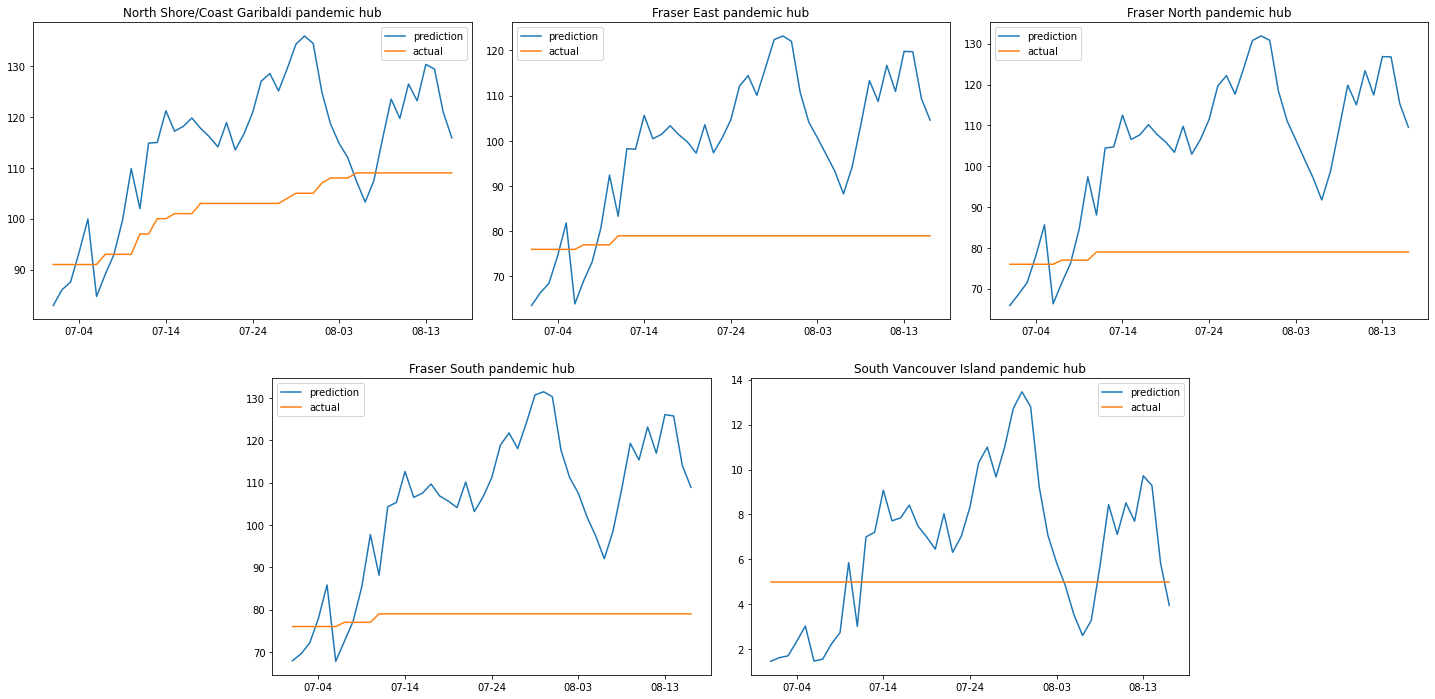

In [250]:

def hr_plot(hr):    
    feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5,'5daypred')
    X_train = feature_train
    X_test = feature_val
    y_train = label_train
    y_test = label_val
#     X_train, X_test, y_train, y_test = train_test_split(
#                          feature_train, label_train, test_size=0.2, random_state=42, shuffle=False)

    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    
    n_sample = 1
    n_step = X_test_3d.shape[0]
    n_features = X_test_3d.shape[-1]
#     x_train = X_train.to_numpy().reshape(n_step, -1,n_features)
#     x_test = X_test.to_numpy().reshape(X_test.shape[0], -1,X_test.shape[-1])
    
    then = df_hr1['report_date'].max()

    end_date = datetime.strftime(then + timedelta(1), '%Y-%m-%d')
    date_end_date = datetime.strptime(end_date, '%Y-%m-%d')

    fst_date = datetime.strftime(then - timedelta(len(X_test_3d)-1), '%Y-%m-%d')
    date_fst_date = datetime.strptime(fst_date, '%Y-%m-%d')


    days = mdates.drange(date_fst_date,date_end_date,dt.timedelta(days=1))


    prediction_90_2 = model_90_2.predict(X_test_3d).flatten()
    
    y_test = y_test.reshape(-1, 1)
    prediction_90_2 = prediction_90_2.reshape(-1, 1)
    
    test_inv = scaler1.inverse_transform(y_test)
    inv_90_2 = scaler1.inverse_transform(prediction_90_2)
    
    return days, test_inv, inv_90_2
    
plt.gcf().set_size_inches(25, 12)  

days, test_inv, inv_90_2 = hr_plot('5933')

plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('North Shore/Coast Garibaldi pandemic hub')
plt.legend(['prediction', 'actual'])
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('5921')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('Fraser East pandemic hub')
plt.legend(['prediction', 'actual'])
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('5922')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('Fraser North pandemic hub')
plt.legend(['prediction', 'actual'])
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('5923')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('Fraser South pandemic hub')
plt.legend(['prediction', 'actual'])
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('5941')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('South Vancouver Island pandemic hub')
plt.legend(['prediction', 'actual'])
# plt.savefig('photo/Reg_plot/mdl90_reg_l2_BC.png')
    
    

In [21]:
rmse_lst = []
mse_lst = []
def Average(lst): 
    return sum(lst) / len(lst)

for hr in df_hr_dum['HR_UID'].unique().tolist():    
    feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5)
#     X_train, X_test, y_train, y_test = train_test_split(
#                          feature_train, label_train, test_size=0.2, random_state=42, shuffle=False)

    
    # val data
    Y_val = label_val.to_numpy().reshape(-1,)
    X_val_3d, y_val = split_sequences(feature_val.to_numpy(), 2, Y_val)
    
    n_sample = 1
    n_step = X_val_3d.shape[0]
    n_features = X_val_3d.shape[-1]
                                      
    prediction_90_2 = model_90_2.predict(X_val_3d).flatten()
    y_val = y_val.reshape(-1, 1)
    prediction_90_2 = prediction_90_2.reshape(-1, 1)
    val_inv = scaler1.inverse_transform(y_val)
    inv_90_2 = scaler1.inverse_transform(prediction_90_2)
                                      
    # normalized
    mse = mean_squared_error(y_val, prediction_90_2)
    # normalized
    rmse = mean_squared_error(y_val, prediction_90_2, squared=False)
    
    rmse_lst.append(rmse)
    mse_lst.append(mse)
                                      
rmse_average = Average(rmse_lst)
mse_average = Average(mse_lst)

In [22]:
print('average rmse:', mse_average)

average rmse: 0.00013250449115531561


## Locate the pandemic hub (one)

In [82]:
# test set
feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter('5941', True,5)
X_train = feature_train
X_test = feature_val
y_train = label_train
y_test = label_val

Y_train = y_train.to_numpy().reshape(-1,)
Y_test = y_test.to_numpy().reshape(-1,)
    
X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    
n_sample = 1
n_step = X_test_3d.shape[0]
n_features = X_test_3d.shape[-1]


test_pred = model_80_2.predict(X_test_3d).flatten()
train_pred = model_80_2.predict(X_train_3d).flatten()
# y_test = y_test.reshape(-1, 1)
test_pred = test_pred.reshape(-1, 1)
train_pred = train_pred.reshape(-1, 1)

# normalized
train_rmse = mean_squared_error(Y_train, train_pred, squared=False)
test_rmse = mean_squared_error(Y_test, test_pred, squared=False)

print('train rmse:', train_rmse)
print('test rmse:', test_rmse)



train rmse: 0.0010140203534662437
test rmse: 0.0015283213169831164


In [70]:
# valid set
feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter('3530', True,5)


Y_val = label_val.to_numpy().reshape(-1,)
    
X_val_3d, y_val = split_sequences(feature_val.to_numpy(), 2, Y_val)
    
n_sample = 1
n_step = X_val_3d.shape[0]
n_features = X_val_3d.shape[-1]

prediction_90_2 = model_90_2.predict(X_val_3d).flatten()
y_val = y_val.reshape(-1, 1)
prediction_90_2 = prediction_90_2.reshape(-1, 1)

test_inv = scaler1.inverse_transform(y_val)
inv_90_2 = scaler1.inverse_transform(prediction_90_2)

## MSE

In [71]:
# not normalized
mean_squared_error(test_inv, inv_90_2)

12.270551344321575

In [72]:
# normalized
mean_squared_error(y_val, prediction_90_2)

1.05031634125621e-06

## RMSE

In [73]:
# not normalized
mean_squared_error(test_inv, inv_90_2, squared=False)

3.5029346759997644

In [74]:
# normalized
mean_squared_error(y_val, prediction_90_2, squared=False)

0.0010248494236990183

## Output overall RMSE score

In [219]:
df_hr_dum['HR_UID'].nunique()

107

In [270]:
# Get the avg pred score on each HR
X_train_lst = []
X_test_lst = []
y_train_lst = []
y_test_lst = []
# SK 47, QC 24, ON 35
# df_qc = df_hr_dum.loc[df_hr_dum['PRUID_x']==str(35)]
# qc_hr = df_qc['HR_UID'].unique().tolist()
qc_hr = df_hr_dum['HR_UID'].unique().tolist()
for hr in qc_hr:
    feature_train, label_train, feature_val,  label_val, df_hr1 = df_filter(hr, True,5,'1daypred')
    X_train = feature_train
    X_test = feature_val
    y_train = label_train
    y_test = label_val
    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
#     print(X_train.shape)
    X_train_3d, y_train = split_sequences(X_train.to_numpy(), 1, Y_train)
    X_test_3d, y_test = split_sequences(X_test.to_numpy(), 1, Y_test)
    
    X_train_lst.append(X_train_3d)
    X_test_lst.append(X_test_3d)
    y_train_lst.append(y_train)
    y_test_lst.append(y_test)
    break

X_train = np.concatenate(X_train_lst, axis=0)
X_test = np.concatenate(X_test_lst, axis=0)
y_train = np.concatenate(y_train_lst, axis=0)
y_test = np.concatenate(y_test_lst, axis=0)


Y_train = y_train.reshape(-1,)
Y_test = y_test.reshape(-1,)
Y_train.shape

(153, 158)


(153,)

In [221]:
## Run
n_sample = 1
n_step = X_train.shape[0]
n_features = X_train.shape[-1]
x_train = X_train.reshape(n_step, -1,n_features)
x_test = X_test.reshape(X_test.shape[0], -1,X_test.shape[-1])

x_train.shape


(16371, 1, 158)

In [222]:
test_pred = model_60_2.predict(x_test).flatten()
train_pred = model_60_2.predict(x_train).flatten()
# y_test = y_test.reshape(-1, 1)
test_pred = test_pred.reshape(-1, 1)
train_pred = train_pred.reshape(-1, 1)

train_rmse = mean_squared_error(Y_train, train_pred, squared=False)
test_rmse = mean_squared_error(Y_test, test_pred, squared=False)

print('train rmse:', train_rmse)
print('test rmse:', test_rmse)

train rmse: 0.018748956441614936
test rmse: 0.03570873399864712


In [39]:
test_pred = model_60_2.predict(x_test).flatten()
train_pred = model_60_2.predict(x_train).flatten()
# y_test = y_test.reshape(-1, 1)
test_pred = test_pred.reshape(-1, 1)
train_pred = train_pred.reshape(-1, 1)

train_rmse = mean_squared_error(Y_train, train_pred)
test_rmse = mean_squared_error(Y_test, test_pred)

print('train mse:', train_rmse)
print('test mse:', test_rmse)

train mse: 0.0001258281628610168
test mse: 0.0007185564926527946
